#Overview

1. Build a neural network from scratch (numpy-only) with forward & backward passes and Adam optimizer.
2. Train it to approximate several functions (sin, tanh, exp, composite) from sampled (x, f(x)).
3. Visualize fitted curve, training loss, and hidden-neuron activations.
4. Derive symbolic approximations:
- Fit a sparse linear model (LASSO via coordinate descent) on an engineered basis (polynomials, sin, cos, exp)
to obtain an interpretable equation.
- Fit a plain polynomial (least-squares) to compare.
5. Provide utilities to print the symbolic equation using SymPy.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Callable, Tuple
import math

In [18]:
try:
  import sympy as sp
  SYMPY_AVAILABLE = True
except Exception:
  SYMPY_AVAILABLE = False

#Dataset Generator

In [19]:
np.random.seed(42)


# Simple plotting helper
def plot_fit(x, y_true, y_pred, title='Fit', show=True):
      plt.figure(figsize=(8,4))
      plt.plot(x, y_true, label='True', linewidth=2)
      plt.plot(x, y_pred, label='Model', linewidth=2, linestyle='--')
      plt.scatter(x, y_pred, s=8, alpha=0.5)
      plt.legend()
      plt.title(title)
      if show:
        plt.show()

In [32]:
def make_dataset(func, x_min=-3, x_max=3, n=400, noise=0.0, test_ratio=0.2):
    x = np.linspace(x_min, x_max, n)
    y = func(x)
    if noise > 0:
        y = y + np.random.normal(scale=noise, size=y.shape)

    # reshape for convenience
    X = x.reshape(-1, 1)
    Y = y.reshape(-1, 1)

    # shuffle and split
    idx = np.arange(n)
    np.random.shuffle(idx)
    split = int(n * (1 - test_ratio))
    train_idx = idx[:split]
    test_idx = idx[split:]

    return X[train_idx], Y[train_idx], X[test_idx], Y[test_idx], x, y



    # example functions
functions = {
  'sin': lambda x: np.sin(x),
  'tanh': lambda x: np.tanh(x),
  'exp': lambda x: np.exp(x/2),
  'polynomial': lambda x: 0.5*x**3 - x**2 + 2*x - 1,
  'composite': lambda x: np.sin(1.5*x) + 0.3*x**2 - 0.5*np.cos(x)
  }

#Neural network (from scratch, numpy)

In [33]:
@dataclass
class Layer:
  W: np.ndarray
  b: np.ndarray
  grad_W: np.ndarray = None
  grad_b: np.ndarray = None
  cache: dict = None

In [43]:
class MLP:
    def __init__(self, layer_sizes, activations):
        assert len(layer_sizes)-1 == len(activations)
        self.layers = []
        self.activations = activations
        for i in range(len(layer_sizes)-1):
            in_dim, out_dim = layer_sizes[i], layer_sizes[i+1]
            W = np.random.randn(in_dim, out_dim) * np.sqrt(2.0/(in_dim+out_dim))
            b = np.zeros((1, out_dim))
            self.layers.append(Layer(W=W, b=b))

    def forward(self, X):
        a = X
        for i, layer in enumerate(self.layers):
            z = a.dot(layer.W) + layer.b
            act = self.activations[i]
            if act == 'tanh':
                a_next = np.tanh(z)
            elif act == 'relu':
                a_next = np.maximum(0, z)
            elif act == 'linear':
                a_next = z
            else:
                raise ValueError(act)
            layer.cache = {'a_prev': a, 'z': z, 'a': a_next}
            a = a_next
        return a

    def compute_loss(self, y_pred, y_true):
        return float(np.mean((y_pred - y_true)**2))

    def backward(self, y_pred, y_true):
        N = y_true.shape[0]
        delta = 2*(y_pred - y_true)/N
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            act = self.activations[i]
            z = layer.cache['z']
            a_prev = layer.cache['a_prev']

            if act == 'tanh':
                dz = delta * (1 - np.tanh(z)**2)
            elif act == 'relu':
                dz = delta * (z > 0).astype(float)
            elif act == 'linear':
                dz = delta
            else:
                raise ValueError(act)

            dW = a_prev.T.dot(dz)
            db = np.sum(dz, axis=0, keepdims=True)
            delta = dz.dot(layer.W.T)

            # ✅ Make sure gradients are stored!
            layer.grad_W = dW
            layer.grad_b = db


#Adam optimizer

In [44]:
class AdamOptimizer:
    def __init__(self, params: List[Layer], lr=1e-3, betas=(0.9,0.999), eps=1e-8):
      self.params = params
      self.lr = lr
      self.b1, self.b2 = betas
      self.eps = eps
      self.m_W = [np.zeros_like(p.W) for p in params]
      self.v_W = [np.zeros_like(p.W) for p in params]
      self.m_b = [np.zeros_like(p.b) for p in params]
      self.v_b = [np.zeros_like(p.b) for p in params]
      self.t = 0


    def step(self):
      self.t += 1
      for i, p in enumerate(self.params):

        gW = p.grad_W
        gb = p.grad_b
        self.m_W[i] = self.b1*self.m_W[i] + (1-self.b1)*gW
        self.v_W[i] = self.b2*self.v_W[i] + (1-self.b2)*(gW**2)
        m_hat = self.m_W[i]/(1-self.b1**self.t)
        v_hat = self.v_W[i]/(1-self.b2**self.t)
        p.W -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
        self.m_b[i] = self.b1*self.m_b[i] + (1-self.b1)*gb
        self.v_b[i] = self.b2*self.v_b[i] + (1-self.b2)*(gb**2)
        m_hat_b = self.m_b[i]/(1-self.b1**self.t)
        v_hat_b = self.v_b[i]/(1-self.b2**self.t)
        p.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)

#Training Loop

In [45]:
def train_model(model: MLP, X_train: np.ndarray, Y_train: np.ndarray, X_val: np.ndarray, Y_val: np.ndarray,
    epochs=2000, batch_size=64, lr=1e-3, verbose=True):
    opt = AdamOptimizer(model.layers, lr=lr)
    n = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': []}
    for ep in range(1, epochs+1):
        perm = np.random.permutation(n)
        for i in range(0, n, batch_size):
            ids = perm[i:i+batch_size]
            xb = X_train[ids]
            yb = Y_train[ids]
            y_pred = model.forward(xb)
            model.backward(y_pred, yb)
            opt.step()
        y_train_pred = model.forward(X_train)
        y_val_pred = model.forward(X_val)
        train_loss = model.compute_loss(y_train_pred, Y_train)
        val_loss = model.compute_loss(y_val_pred, Y_val)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if verbose and (ep % max(1, epochs//10) == 0 or ep==1):
          print(f"Epoch {ep}/{epochs} train_loss={train_loss:.6f} val_loss={val_loss:.6f}")
        return history

#Basis engineering and symbolic approximation (LASSO via coordinate descent)

In [46]:
def make_basis_functions(x: np.ndarray, poly_deg=6, include_trig=True, include_exp=True) -> Tuple[np.ndarray, List[str]]:

    xx = x.flatten()
    cols = []
    names = []
    cols.append(np.ones_like(xx))
    names.append('1')
    for d in range(1, poly_deg+1):
      cols.append(xx**d)
      names.append(f'x^{d}')
    if include_trig:
      cols.append(np.sin(xx))
      names.append('sin(x)')
      cols.append(np.cos(xx))
      names.append('cos(x)')
    if include_exp:
      cols.append(np.exp(xx))
      names.append('exp(x)')
      cols.append(np.exp(xx/2))
      names.append('exp(x/2)')

    A = np.vstack(cols).T

    col_norms = np.linalg.norm(A, axis=0)
    col_norms[col_norms==0] = 1.0
    A_normed = A / col_norms
    return A_normed, names, col_norms

#Coordinate descent LASSO (standard algorithm). We minimize 0.5||Ax - y||^2 + alpha * ||x||_1

In [47]:
def lasso_coordinate_descent(A: np.ndarray, y: np.ndarray, alpha=1e-2, max_iter=1000, tol=1e-6):
# A: (n, m), y: (n,)
  n, m = A.shape
  coef = np.zeros(m)
  col_sq_norms = np.sum(A**2, axis=0)
  for it in range(max_iter):
      coef_old = coef.copy()
      for j in range(m):
          residual = y - A.dot(coef) + A[:,j]*coef[j]
          rho = A[:,j].dot(residual)
          if col_sq_norms[j] == 0:
              coef[j] = 0.0
              continue
          z = rho/col_sq_norms[j]

          if z > alpha/col_sq_norms[j]:
            coef[j] = z - alpha/col_sq_norms[j]
          elif z < -alpha/col_sq_norms[j]:
            coef[j] = z + alpha/col_sq_norms[j]
          else:
            coef[j] = 0.0

      if np.max(np.abs(coef - coef_old)) < tol:
        break
  return coef

In [48]:

def coefficients_to_expression(coef_normed: np.ndarray, names: List[str], col_norms: np.ndarray, threshold=1e-6):
  true_coefs = coef_normed / col_norms
  terms = []
  for c, name in zip(true_coefs, names):
    if abs(c) > threshold:
      terms.append(f"({c:.6g})*{name}")
  if len(terms) == 0:
    return '0'
  return ' + '.join(terms)

In [49]:
def to_sympy_expr(coef_normed: np.ndarray, names: List[str], col_norms: np.ndarray):
    if not SYMPY_AVAILABLE:
      raise RuntimeError('SymPy not available')
    true_coefs = coef_normed / col_norms
    x = sp.symbols('x')
    expr = 0
    for c, name in zip(true_coefs, names):
      if abs(c) < 1e-9:
        continue
      if name == '1':
        expr += sp.Rational(str(c))
      elif name.startswith('x^'):
        deg = int(name.split('^')[1])
        expr += sp.nsimplify(c) * x**deg
      elif name == 'sin(x)':
        expr += sp.nsimplify(c) * sp.sin(x)
      elif name == 'cos(x)':
        expr += sp.nsimplify(c) * sp.cos(x)
      elif name == 'exp(x)':
        expr += sp.nsimplify(c) * sp.exp(x)
      elif name == 'exp(x/2)':
         expr += sp.nsimplify(c) * sp.exp(x/2)
      else:

        expr += sp.nsimplify(c) * sp.Symbol(name)
    return sp.simplify(expr)

In [50]:
def run_experiment(func_name='sin', hidden_sizes=[32,32], activations=['tanh','tanh','linear'],
    epochs=2000, lr=1e-3, noise=0.0, alpha=1e-3):
    print(f"Running experiment for: {func_name}")
    func = functions[func_name]
    X_train, Y_train, X_test, Y_test, full_x, full_y = make_dataset(func, x_min=-3, x_max=3, n=400, noise=noise)
    # build model
    sizes = [1] + hidden_sizes + [1]
    model = MLP(layer_sizes=sizes, activations=activations)
    # train
    history = train_model(model, X_train, Y_train, X_test, Y_test, epochs=epochs, lr=lr, verbose=True)
    plt.figure()
    plt.plot(history['train_loss'], label='train')
    plt.plot(history['val_loss'], label='val')
    plt.yscale('log')
    plt.legend(); plt.title('Training Loss'); plt.show()
    x_grid = np.linspace(-3,3,600).reshape(-1,1)
    y_pred_grid = model.forward(x_grid)
    plot_fit(x_grid.flatten(), func(x_grid.flatten()), y_pred_grid.flatten(), title=f'Neural Net Fit for {func_name}')
    if len(model.layers) >= 2:

        first_layer = model.layers[0]
        z1 = x_grid.dot(first_layer.W) + first_layer.b
        a1 = np.tanh(z1) if activations[0]=='tanh' else np.maximum(0,z1)
        plt.figure(figsize=(8,4))
        for i in range(min(6, a1.shape[1])):
          plt.plot(x_grid.flatten(), a1[:,i], label=f'neuron {i}')
        plt.title('First hidden layer activations (sample neurons)')
        plt.legend(); plt.show()
    A, names, col_norms = make_basis_functions(x_grid, poly_deg=6, include_trig=True, include_exp=True)
    y_grid = func(x_grid.flatten())
    coef_normed = lasso_coordinate_descent(A, y_grid, alpha=alpha, max_iter=5000)
    expr_str = coefficients_to_expression(coef_normed, names, col_norms, threshold=1e-6)
    print('\nSparse basis approximation (LASSO) yields:')
    print(expr_str)
    if SYMPY_AVAILABLE:
      try:
        symexpr = to_sympy_expr(coef_normed, names, col_norms)
        print('\nSymPy expression (simplified):')
        sp.pprint(symexpr)
      except Exception as e:
         print('Could not convert to SymPy:', e)

    p_coeffs = np.polyfit(x_grid.flatten(), y_grid, deg=6)
    poly_pred = np.polyval(p_coeffs, x_grid.flatten())
    plt.figure(figsize=(8,4))
    plt.plot(x_grid.flatten(), y_grid, label='True')
    plt.plot(x_grid.flatten(), poly_pred, '--', label='Poly deg6')
    plt.legend(); plt.title('Polynomial fit (degree 6) comparison'); plt.show()

    return {
    'model': model,
    'history': history,
    'x_grid': x_grid,
    'y_pred_grid': y_pred_grid,
    'lasso_coef': coef_normed,
    'lasso_names': names,
    'lasso_col_norms': col_norms,
    'poly_coeffs': p_coeffs
}

Running experiment for: sin
Epoch 1/1200 train_loss=0.147353 val_loss=0.144050


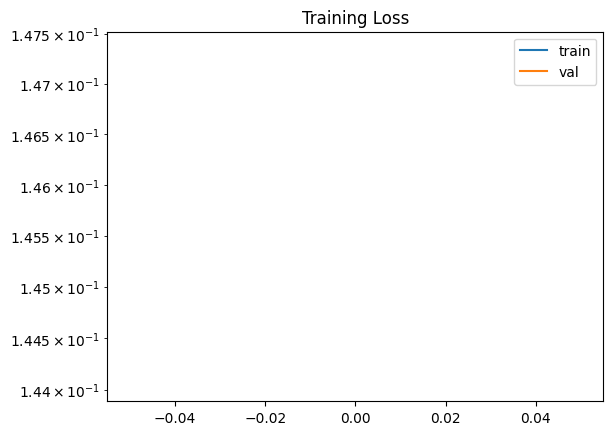

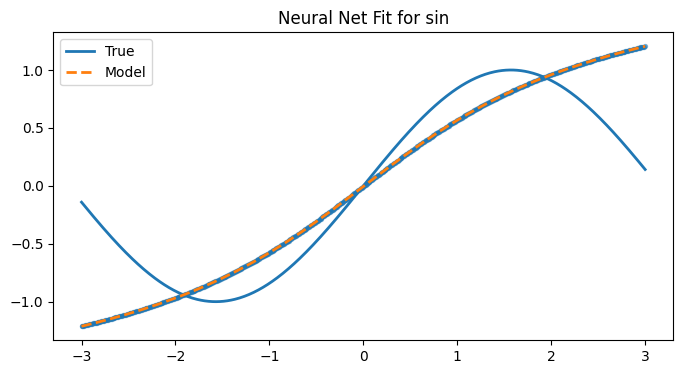

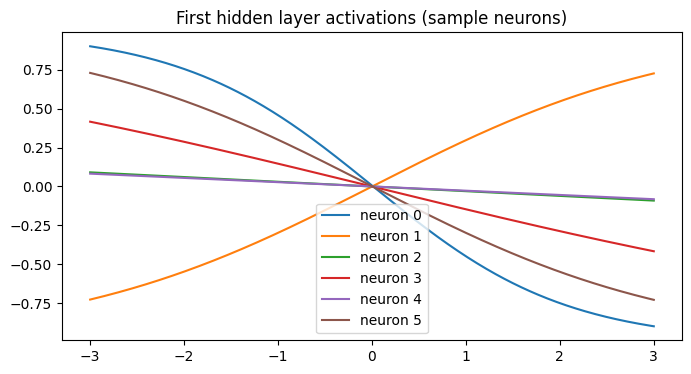


Sparse basis approximation (LASSO) yields:
(0.999831)*sin(x)

SymPy expression (simplified):
249957639079171⋅sin(x)
──────────────────────
   250000000000000    


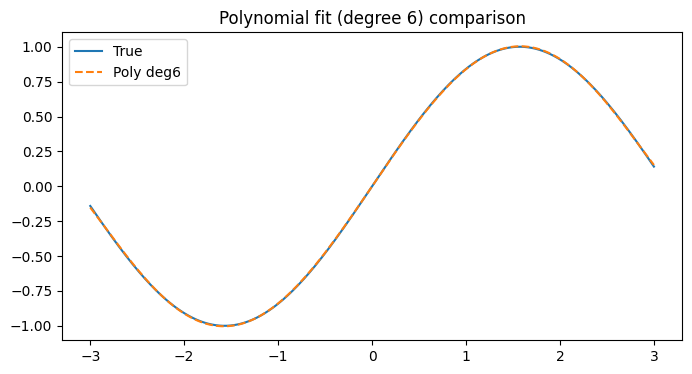

Running experiment for: composite
Epoch 1/1200 train_loss=2.599037 val_loss=2.038960


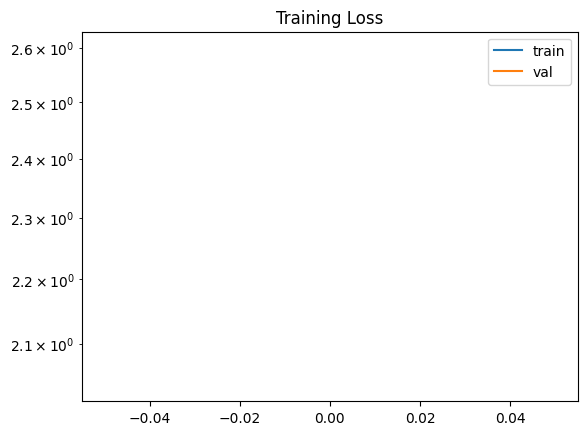

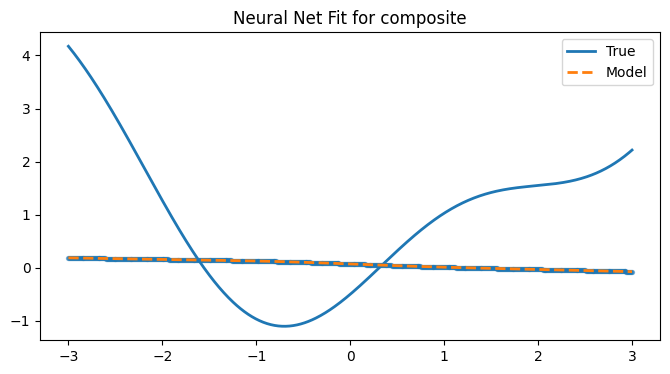

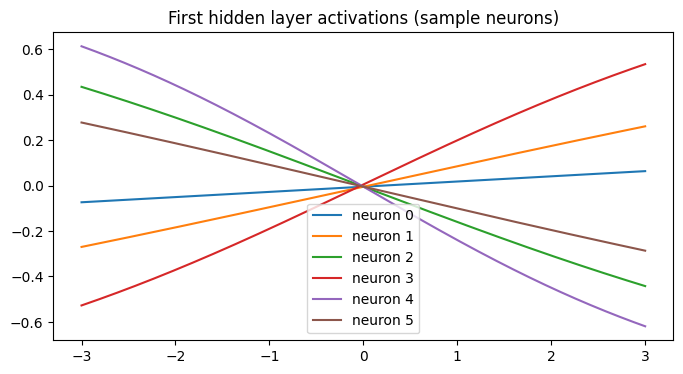


Sparse basis approximation (LASSO) yields:
(0.143682)*1 + (-0.853696)*x^1 + (0.313893)*x^2 + (-0.0577825)*x^3 + (0.00340971)*x^4 + (0.0142615)*x^5 + (2.3271)*sin(x) + (-0.526438)*cos(x) + (-0.0387649)*exp(x) + (-0.0774785)*exp(x/2)

SymPy expression (simplified):
                                                                               ↪
                                                                               ↪
                 5                    4                    3                   ↪
142615220271881⋅x    340971311375107⋅x    288912540164633⋅x    78473189533063⋅ ↪
────────────────── + ────────────────── - ────────────────── + ─────────────── ↪
10000000000000000    100000000000000000    5000000000000000     25000000000000 ↪

↪                                          x                                   ↪
↪                                          ─                                   ↪
↪  2                                       2                    x              ↪
↪ x  

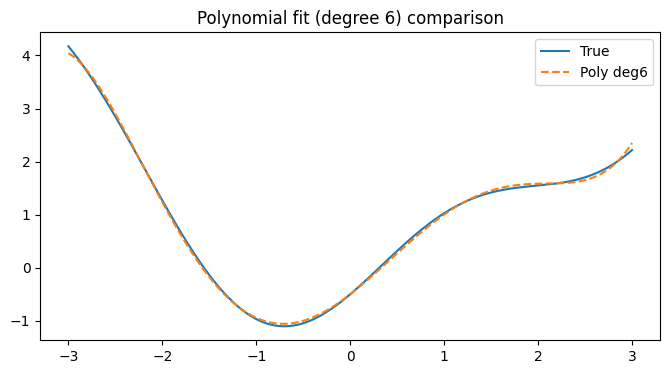

Done. Explore the returned objects for neuron activations, weights, and coefficients.


In [51]:
if __name__ == '__main__':
  res_sin = run_experiment('sin', hidden_sizes=[48,24], activations=['tanh','tanh','linear'], epochs=1200, lr=2e-3, alpha=3e-3)
  res_comp = run_experiment('composite', hidden_sizes=[64,32], activations=['tanh','tanh','linear'], epochs=1200, lr=1e-3, alpha=5e-3)
  print('Done. Explore the returned objects for neuron activations, weights, and coefficients.')